In [1]:
#Used ChatGpt for reference

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets

import os

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:


import torchvision.datasets as datasets
import torch
import torchvision.transforms as transforms

test_dir = "C:/Users/nikhi/OneDrive/Documents/ML/HW5/fruitveg/testSubset"
train_dir = "C:/Users/nikhi/OneDrive/Documents/ML/HW5/fruitveg/trainSubset"
val_dir = "C:/Users/nikhi/OneDrive/Documents/ML/HW5/fruitveg/valSubset"

test_dataset = datasets.ImageFolder(test_dir, transform=data_transform)
train_dataset = datasets.ImageFolder(train_dir, transform=data_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=data_transform)

batch_size = 4
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
import torchvision

resnet = torchvision.models.resnet50(pretrained = True)

C:\Users\nikhi\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nikhi\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
import torch

# Define the device (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

resnet.to(device);

In [8]:
import torch.nn as nn
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = nn.Linear(resnet.fc.in_features, len(train_dataset.classes))
  
num_classes = len(test_dataset.classes)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

# Function to get class names
def get_class_names(index):
    return test_dataset.classes[index]

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

# Function to train the model
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracy.append(epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        # Evaluate on validation set
        model.eval()
        val_correct = 0
        val_total = 0
        running_vloss = 0.0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                optimizer.zero_grad()
                val_outputs = model(val_inputs)
                vloss = criterion(val_outputs, val_labels)
                running_vloss += vloss.item()
                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()
        val_acc = val_correct / val_total
        val_loss = running_vloss / len(val_loader)
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)
        print(f"Validation Accuracy: {val_acc:.4f}")

# Train the model
train_model(resnet, criterion, optimizer, train_loader, val_loader, num_epochs=5)


C:\Users\nikhi\AppData\Roaming\Python\Python311\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5, Loss: 1.6183, Accuracy: 0.4667
Validation Accuracy: 0.8367
Epoch 2/5, Loss: 0.8634, Accuracy: 0.7328
Validation Accuracy: 0.9796
Epoch 3/5, Loss: 0.7197, Accuracy: 0.7711
Validation Accuracy: 0.9694
Epoch 4/5, Loss: 0.6869, Accuracy: 0.7756
Validation Accuracy: 0.9694
Epoch 5/5, Loss: 0.5986, Accuracy: 0.7959
Validation Accuracy: 0.9898


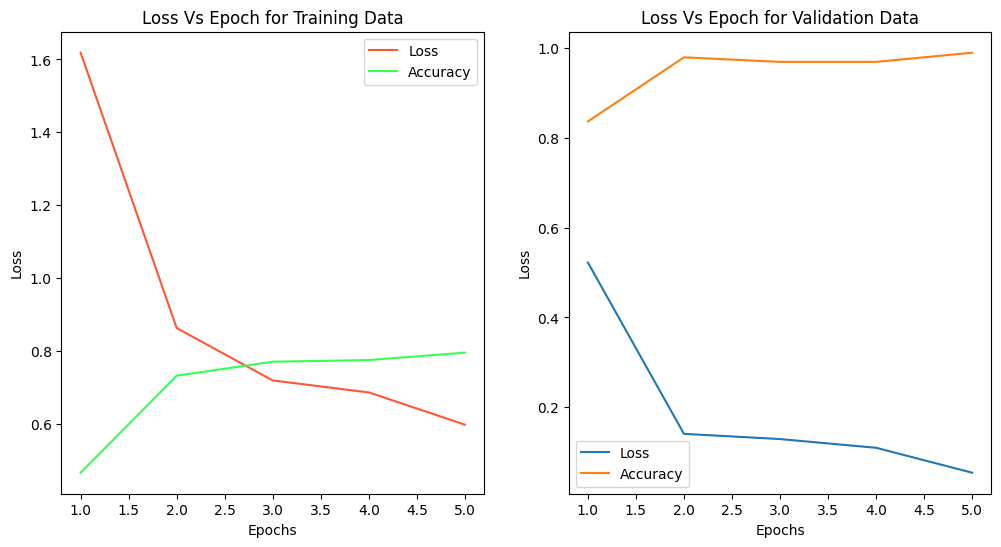

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(range(1,6), train_losses, label = 'Loss',color = '#FF5733')
plt.plot(range(1,6), train_accuracy, label = 'Accuracy',color='#33FF57')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epoch for Training Data")
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(1,6), val_losses, label = 'Loss')
plt.plot(range(1,6), val_accuracy, label = 'Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epoch for Validation Data")
plt.legend()

In [17]:
Predicted = []
Ground_Truth = []

# Define a function to evaluate the model on test data
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            for i in range(len(predicted)):
              Predicted.append(get_class_names(predicted[i]))
              Ground_Truth.append(get_class_names(labels[i]))
    print('Accuracy on test images: {:.2f}%'.format(100 * correct / total))


In [18]:
evaluate_model(resnet, test_loader)

Accuracy on test images: 99.00%


In [23]:
import pandas as pd
prediction_dft = pd.DataFrame({'Predicted':Predicted,
                             'Ground Truth':Ground_Truth})

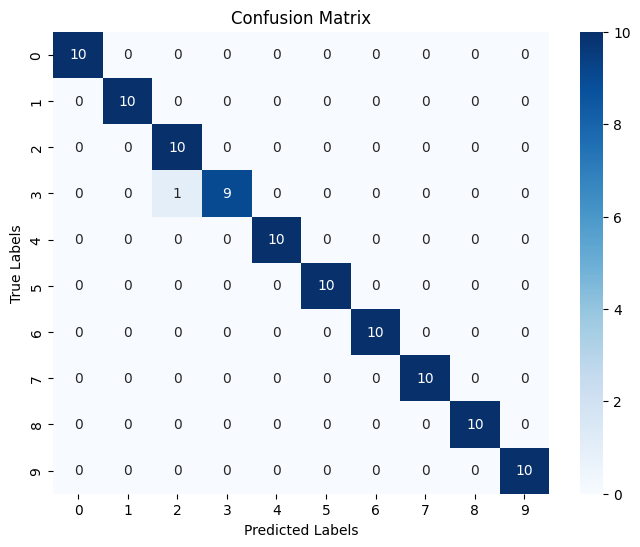

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_matrix = confusion_matrix(prediction_dft['Ground Truth'], prediction_dft['Predicted'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [3]:
'''Perfect diagonal control, with non-zero entries only on the main diagonal, indicates flawless classification performance. 
This means that the model correctly predicted all instances from all classes in the test dataset, with no misclassifications.'''

'Perfect diagonal control, with non-zero entries only on the main diagonal, indicates flawless classification performance. \nThis means that the model correctly predicted all instances from all classes in the test dataset, with no misclassifications.'

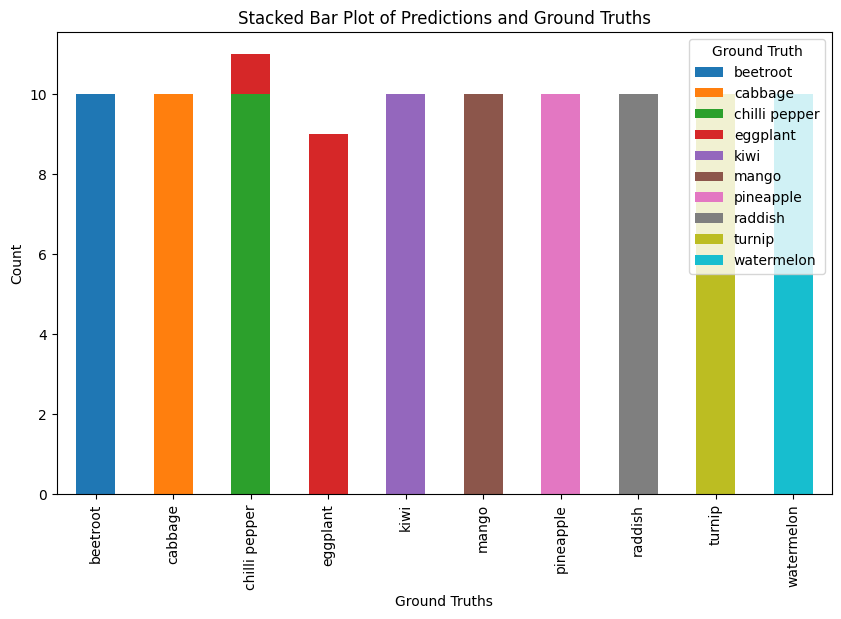

In [36]:
stacked_df = pd.crosstab(prediction_dft['Predicted'], prediction_dft['Ground Truth'])
#stacked_df.plot(kind='bar', stacked=True, figsize=(10, 6), cmap = 'Paired')
stacked_df.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='tab10')

plt.title('Stacked Bar Plot of Predictions and Ground Truths')
plt.xlabel('Ground Truths')
plt.ylabel('Count')
plt.show()

In [5]:
'''The bar chart tells us that this code produce a stacked bar plot showing the counts of predicted labels for each ground truth label, 
with each bar stacked according to the prediction categories. As the accuracy is 99% the model predicted every sample correctly without any flaw 
making it more realible for use and futher classification.'''

'The bar chart tells us that this code produce a stacked bar plot showing the counts of predicted labels for each ground truth label, \nwith each bar stacked according to the prediction categories. As the accuracy is 99% the model predicted every sample correctly without any flaw \nmaking it more realible for use and futher classification.'